<center>
<img src="https://raw.githubusercontent.com/FUlyankin/ekenam_grand_research/master/images/cover.png">
</center>


# <center> Иканам гранд рисёрч </center>
## <center>  Часть седьмая: моделирование </center>


Проект **Иканам гранд рисёрч** реализуется [Иканам стьюдентс коммьюнити,](https://vk.com/ikanam)
в частности [вот этим парнем по имени Филипп.](https://vk.com/ppilif)  Если вы нашли ошибку или у вас есть предложения, замечания, деньги, слава или женщины, можно ему написать. Весь говнокод, использованный в исследовании распостраняется по лицензии [Creative Commons CC BY-NC-SA 4.0.](https://creativecommons.org/licenses/by-nc-sa/4.0/) Его можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала. При наличии технической возможности необходимо также указать активную гиперссылку на [страницу рисёрча.](https://github.com/FUlyankin/ekenam_grand_research) 


In [122]:
import warnings     # Игнорирование варнингов
warnings.filterwarnings("ignore")  

In [123]:
import numpy as np     # Нумпай для векторов 
import pandas as pd    # Пандас для табличек 
# Округлять в табличках значения до второго знака
pd.set_option('precision', 2)           

# Пакеты для графииков
import matplotlib
import matplotlib.pyplot as plt                             
import seaborn as sns
plt.style.use('ggplot')   # Правильный стиль графиков   

# Пакет для красивых циклов. При желании его можно отключить. Тогда из всех циклов придётся 
# удалять команду tqdm_notebook.
from tqdm import tqdm_notebook   # подробнее: https://github.com/tqdm/tqdm

In [124]:
%matplotlib inline  

# 1. Подгрузка данных и их дробление 

Все названия переменных я, конечно же копировал из прошлого файла. 

In [125]:
# Подгрузили файлик с описание переменных 
des_var = pd.read_csv('variables.csv', sep=';')
print(des_var.shape)

# Подгрузили самые полные данные. После очистки данных, некоторые фичи, которые есть в описании
# исчезли из таблички с данными.  Придётся взять пересечение столбцов и переменных из описания. 
data = pd.read_csv('data5_prof_ph_wl_pub.csv', sep='\t', index_col=False)

# проиндексируем табличку с переменными названиями 
des_var.set_index('name',inplace=True)
# возьмём ту её часть, которая соответствует колонкам 
des_var = des_var.ix[data.columns.get_values( ),:]
# сбрасываем индекс
des_var.reset_index(inplace=True)

# Создаём списки из переменных для картинок и скалирования 
real_set = set(des_var[des_var['type'] == 'real']['name'])
cnt_set= des_var[des_var['type'] == 'cnt']['name'].get_values()
cat_set = des_var[des_var['type'] == 'cat']['name'].get_values()
dummy_set = des_var[des_var['type'] == 'dummy']['name'].get_values()

# Откидываем переменные, к которым я отношусь скептически
print(des_var.shape)
bad_vars = des_var[des_var['my_opinion'] == -1]['name'].get_values()
des_var = des_var[des_var['my_opinion'] > -1]
print(des_var.shape)

des_var.head()

(196, 5)
(181, 5)
(100, 5)


,name,des,type,source,my_opinion
0,uids,id вконтакте,teh,profile,0.0
1,firstname,имя,teh,profile,0.0
2,lastname,фамилия,teh,profile,0.0
4,prohodnoy,проходной балл в год поступления,real,order,0.0
5,lgota,была ли льгота,dummy,order,1.0


In [127]:
# ешё одна подгрузка той же таблички для удобства
data = pd.read_csv('data5_prof_ph_wl_pub.csv', sep='\t', index_col=False)

# Выбрасываем разные не очень важные куски. Здесь мы будем то комментировать, то снимать комментарии и прогонять 
# дальше всё время один и тот же код для разных подвыборок 

# Выбрасываем переменные, которым я не верю 
data.drop(bad_vars, axis=1, inplace = True)

# выкинуть всех кто без id 
data.dropna(subset=['uids'],axis=0,inplace=True)

# 1.Технические переменные
data.drop(['profile_first_name', 'profile_last_name', 'wall_repost_groups_id','wall_repost_people_id',
           'wall_repost_groups_id', 'wall_repost_people_id'] ,axis=1, inplace = True)

# 2.Переменные по приказам
data.drop(['prohodnoy', 'kurs', 'zima', 'leto', 'akadem', 'target_2', 'target_3', 'target_4'], axis=1, inplace = True)

# data.drop(['lgota', 'chelevoe', 'olimp', 'dogovor', 'ochko-zaochka', 'ege_diff', 'kozko'], axis=1, inplace = True)

# 3. Субъективные переменные 
data.hodit_tusa.fillna(data.hodit_tusa.mean(), inplace= True)     # Внимание! В пеерменных остались пропуски
data.hodit_para.fillna(data.hodit_para.mean(), inplace = True)    # Заполняем их средними
data.drop([ 'hodit_para','hodit_tusa'], axis=1, inplace = True)

# 4. Переменные, которые отвечают за профиль
# Дамми
uslovie = (des_var['source'] == 'profile')&(des_var['type'] == 'dummy')
# data.drop(des_var[uslovie]['name'].get_values() ,axis=1, inplace = True)

# Счётчики 
uslovie = (des_var['source'] == 'profile')&(des_var['type'] == 'cnt')
# data.drop(des_var[uslovie]['name'].get_values() ,axis=1, inplace = True)

# Категориальные
# Заполним все пропуски каким-нибудь символом для выделения отдельных дамми под них
cat_vars = [var for var in data.columns if var in cat_set]
X_cat = pd.get_dummies(data[cat_vars].fillna('NA').applymap(str))
X_cat['uids'] = data.uids
# data = pd.merge(data,X_cat,on='uids', how='left')
data.drop('uids', axis=1, inplace=True)

uslovie = (des_var['source'] == 'profile')&(des_var['type'] == 'cat')
data.drop(des_var[uslovie]['name'].get_values() ,axis=1, inplace = True)


# 5. Переменные, которые отвечают за фотки
# Cчётчики
uslovie = (des_var['source'] == 'photo')&(des_var['type'] == 'cnt')
#data.drop(des_var[uslovie]['name'].get_values() ,axis=1, inplace = True)

# Реальные 
uslovie = (des_var['source'] == 'photo')&(des_var['type'] == 'real')
#data.drop(des_var[uslovie]['name'].get_values() ,axis=1, inplace = True)


# 6. Переменные, которые отвечают за стенку 
# Cчётчики
uslovie = (des_var['source'] == 'wall')&(des_var['type'] == 'cnt')
# data.drop(des_var[uslovie]['name'].get_values() ,axis=1, inplace = True)

# Реальные 
uslovie = (des_var['source'] == 'wall')&(des_var['type'] == 'real')
# data.drop(des_var[uslovie]['name'].get_values() ,axis=1, inplace = True)

# Дамми
wl_dummy_var = ['wall_can_comment']
# data.drop(wl_dummy_var,axis=1, inplace = True)


# 7. Переменные, которые относятся к пабликам
pub_20_vars = ['20pub_clust_' + str(i) for i in range(20)]
data.drop(pub_20_vars, axis=1, inplace=True)

pub_30_vars = ['30pub_clust_' + str(i) for i in range(30)] + ['pub_likes_cnt']
#data.drop(pub_30_vars, axis=1, inplace=True)

data.head()

,firstname,lastname,year,lgota,chelevoe,olimp,dogovor,ochko-zaochka,ege_diff,kozko,...,30pub_clust_21,30pub_clust_22,30pub_clust_23,30pub_clust_24,30pub_clust_25,30pub_clust_26,30pub_clust_27,30pub_clust_28,30pub_clust_29,pub_likes_cnt
0,Данильченко,Леонид,2012,0,0.0,1,0,0,-44.0,0,...,2.06e-03,0.03,1.41e-03,2.17e-03,9.21e-02,9.42e-03,5.37e-03,0.09,6.87e-04,16.0
1,Лисовская,Людмила,2012,0,0.0,1,0,0,8.0,0,...,3.41e-02,0.04,7.42e-03,1.98e-03,2.03e-02,5.58e-03,6.94e-03,0.05,4.50e-04,3.0
2,Кочеткова,Полина,2012,0,0.0,1,0,0,2.0,0,...,2.42e-02,0.04,1.08e-03,4.11e-03,9.21e-02,6.56e-03,1.89e-02,0.04,0.00e+00,66.0
3,Канаева,Дельгир,2012,1,0.0,0,0,0,-5.0,0,...,1.57e-02,0.01,0.00e+00,0.00e+00,1.07e-01,1.52e-03,4.37e-02,0.01,1.79e-02,0.0
4,Климова,Екатерина,2012,1,0.0,0,0,0,-44.0,0,...,1.75e-02,0.01,6.30e-04,6.30e-04,4.79e-03,1.77e-02,2.19e-02,0.06,6.30e-04,14.0


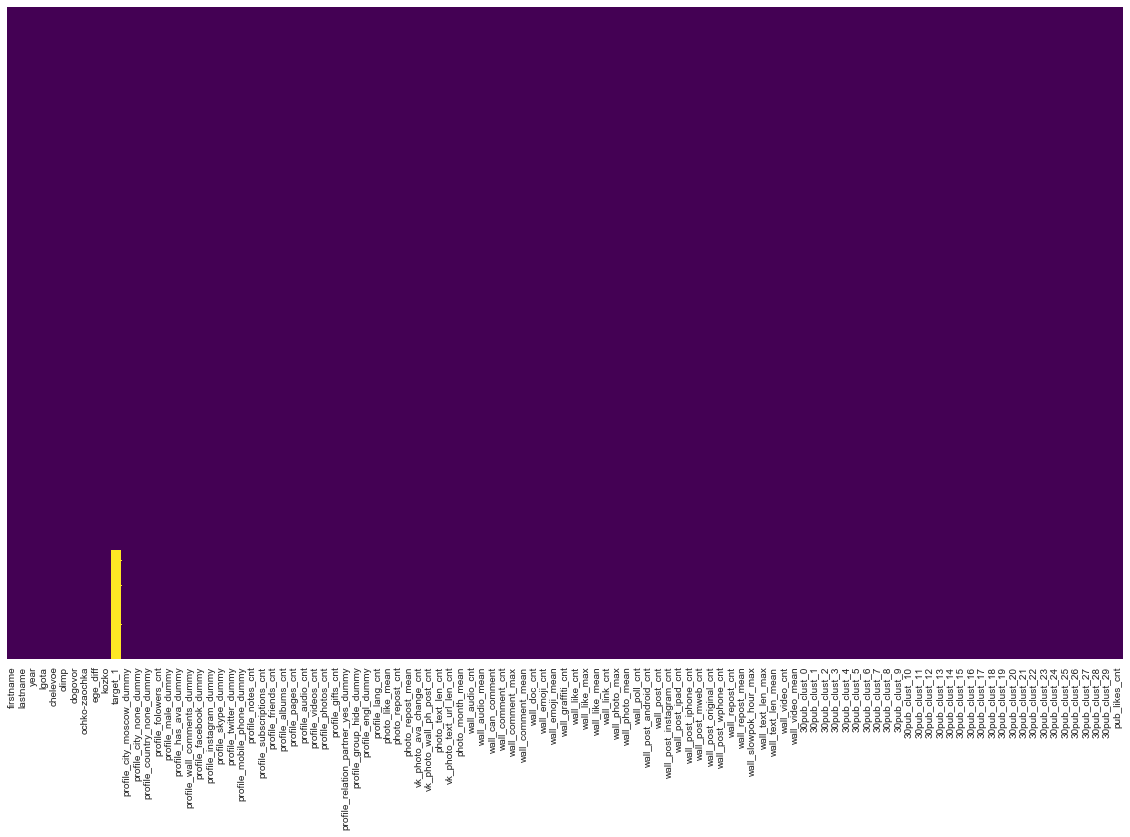

In [128]:
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [129]:
# Подмножества для опытов 
pub_wall = ['year','target_1','firstname', 'lastname',
            'ege_diff', 'wall_can_comment', 'wall_comment_max', 'wall_post_iphone_cnt',
            'wall_video_mean', '20pub_clust_0', '20pub_clust_3']

all_pub_20 = ['year','target_1','firstname', 'lastname',
              'ochko-zaochka', 'profile_folowers_cnt', 'profile_albums_cnt', 'photo_like_mean',
              'wall_can_comment', 'wall_emoji_mean', 'wall_post_android_cnt', 'wall_post_ipad_cnt',
              'wall_repost_mean', 'wall_video_cnt', 'wall_video_mean','20pub_clust_9', '20pub_clust_11']

#data = data[all_pub]

Разбиваем оставшуюся табличку на тестовую и тренировочную выборки. 

In [130]:
# Убираем 2017 год 
X_2017 = data[data.year == 2017].drop(['year','target_1'],axis=1)

# Запоминаем имена для прогнозов 
names_2017 = X_2017.firstname.get_values() + np.array([' ']*X_2017.shape[0]) + X_2017.lastname.get_values()
X_2017.drop(['firstname', 'lastname'], axis=1, inplace=True)

# Выделяем 2016 год как тестовую выборку 
X_test = data[data.year == 2015].drop(['year','target_1'],axis=1)
names_2016 = X_test.firstname.get_values() + np.array([' ']*X_test.shape[0]) + X_test.lastname.get_values()
X_test.drop(['firstname', 'lastname'], axis=1, inplace=True)
y_test = data[data.year == 2015]['target_1'].get_values()

# Выделяем остальное как тернировочную выборку
X_train = data[(data.year != 2017)&(data.year != 2015)].drop(['year','target_1'],axis=1)
X_train.drop(['firstname', 'lastname'], axis=1, inplace=True)
y_train = data[(data.year != 2017)&(data.year != 2015)]['target_1'].get_values()

# списки переменных для табличек
real_vars = [var for var in X_train.columns if var in real_set]
cnt_vars = [var for var in X_train.columns if var in cnt_set]
dummy_vars = [var for var in X_train.columns if var in dummy_set]

# Немного стандартизации для непрерывных переменных
from sklearn.preprocessing import StandardScaler  # Для непрерывных переменных 
from sklearn.preprocessing import MinMaxScaler    # Для счётчиков 
sscaler = StandardScaler()
mscaler = MinMaxScaler()

try:
    X_train[real_vars] = sscaler.fit_transform(X_train[real_vars])
    X_test[real_vars] = sscaler.transform(X_test[real_vars])
    X_2017[real_vars] = sscaler.transform(X_2017[real_vars])
except:
    print('Нет реальных переменных')

try:
    X_train[cnt_vars] = mscaler.fit_transform(X_train[cnt_vars])
    X_test[cnt_vars] = mscaler.transform(X_test[cnt_vars])
    X_2017[cnt_vars] = sscaler.transform(X_2017[cnt_vars])
except:
    print('Нет счётчиков')

    
# Мне влом переводить весь тот же самый код на R 
# Поэтому просто сохраняем нашу табличку для него
data1 = X_train.copy()
data1['target_1'] = y_train
data1.to_csv('train_data_for_R.csv', sep=';',header=True, index=False)
data2 = X_test.copy()
data2['target_1'] = y_test
data2.to_csv('test_data_for_R.csv', sep=';',header=True, index=False)

# Запоминаем в отдельный массив названия переменных 
varnames = X_train.columns.get_values()

# Вытаскиваем матрицы
X_train = X_train.get_values()
X_test = X_test.get_values()

print('\n Метки:', '\n', y_test[:10], '\n')
print('Переменные: \n', X_test[:2], '\n')

print('Всего:', data.shape)
print('Трэйн:', X_train.shape, y_train.shape)
print('Тест:', X_test.shape, y_test.shape)

print('Число переменных:', len(varnames))
# print('действительных: ' + str(len(real_vars)),'счётчиков: ' + str(len(cnt_vars)),
#       'дамми: ' + str(len(dummy_vars)),'категориальных: ' + str(len(cat_vars)), sep=', ')

Нет счётчиков

 Метки: 
 [ 1.  0.  1.  0.  1.  1.  0.  1.  1.  1.] 

Переменные: 
 [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   8.68093913e-01   1.00000000e+00   1.00000000e+00
    0.00000000e+00   0.00000000e+00   6.26151013e-02   0.00000000e+00
    1.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   1.14942529e-02
    0.00000000e+00   3.78563823e-02   0.00000000e+00   2.54596888e-02
    1.76827844e-01   1.35762772e-02   0.00000000e+00   4.68468468e-01
    0.00000000e+00   0.00000000e+00   1.00000000e+00   6.00000000e-01
    8.77368076e-01   1.33333333e-01   2.03430627e-01   5.75539568e-02
    1.02760736e-01   0.00000000e+00   0.00000000e+00  -1.12660169e-01
    7.26392252e-03  -3.83887227e-01   1.00000000e+00   3.20552147e-02
    2.15987061e-02   1.51899873e+00   0.00000000e+00   9.96842580e-02
    4.43328810e+00   0.00000000e+00   2.38406587e-01   1.66274727e-01
    1.1

# 2. Константный прогноз 

Посмотрим на константный прогноз, чтобы было с чем сранвинвать. 

In [131]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score

n_train = y_train.shape[0]
n_test = y_test.shape[0]

print('Трэйн:')
print('accuracy_0 :', accuracy_score(y_train, [0]*n_train))
print('accuracy_1 :', accuracy_score(y_train, [1]*n_train))
print('roc-auc:', roc_auc_score(y_train, np.ones(y_train.shape)))

print( '\n', 'Тест:')
print('accuracy_0 :', accuracy_score(y_test, [0]*n_test))
print('accuracy_1 :', accuracy_score(y_test, [1]*n_test))
print ('roc-auc:', roc_auc_score(y_test, np.ones(y_test.shape)))

Трэйн:
accuracy_0 : 0.290441176471
accuracy_1 : 0.709558823529
roc-auc: 0.5

 Тест:
accuracy_0 : 0.210526315789
accuracy_1 : 0.789473684211
roc-auc: 0.5


Вывод: любая модель с точностью менее 70% сразу отправляется на помойку. 

# 3. Регрессия - моя профессия 

In [132]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

# Функция для вывода метрик качества
def printer(model, y_train=y_train, y_test=y_test, X_train=X_train, X_test=X_test):
    y_hat_train = model.predict_proba(X_train)[:,1]
    y_hat_test = model.predict_proba(X_test)[:,1]
    print ('Train accuracy', accuracy_score(y_train, model.predict(X_train)))
    print ('Test accuracy', accuracy_score(y_test, model.predict(X_test)), '\n')
    print ('Train roc-auc', roc_auc_score(y_train, y_hat_train))
    print ('Test roc-auc', roc_auc_score(y_test, y_hat_test))
    
# Функция для отрисовки roc-auc кривой    
def roc_auc_pic(model, y_train=y_train, y_test=y_test, X_train=X_train, X_test=X_test):
    y_hat_train = model.predict_proba(X_train)[:,1]
    y_hat_test = model.predict_proba(X_test)[:,1]
    
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_hat_train)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
    roc_auc_train = roc_auc_score(y_train, y_hat_train)
    roc_auc_test = roc_auc_score(y_test, y_hat_test)

    matplotlib.rcParams['figure.figsize'] = (8, 8)
    plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
    plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
  

 # Функция для отрисовки конфьюжн матрикс 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=30)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    

Качество на кросс-валидации: 0.519714912281 

Train accuracy 0.944852941176
Test accuracy 0.552631578947 

Train roc-auc 0.986882665442
Test roc-auc 0.55625


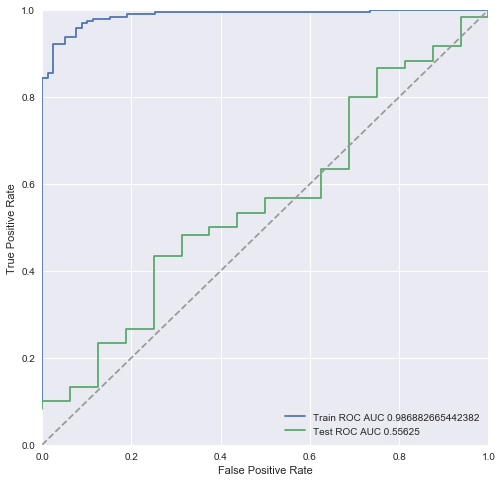

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

# Обучаем логистическую регрессию 
lr = LogisticRegression(C=10**10)
lr.fit(X_train, y_train)

# Качество модели на кросс-валидации 
scoring = cross_val_score(lr, X_train, y_train, scoring = 'roc_auc', cv =5)
print('Качество на кросс-валидации:', scoring.mean(), '\n')

# Качество на трэйне и тесте и картинка
printer(lr)
roc_auc_pic(lr)

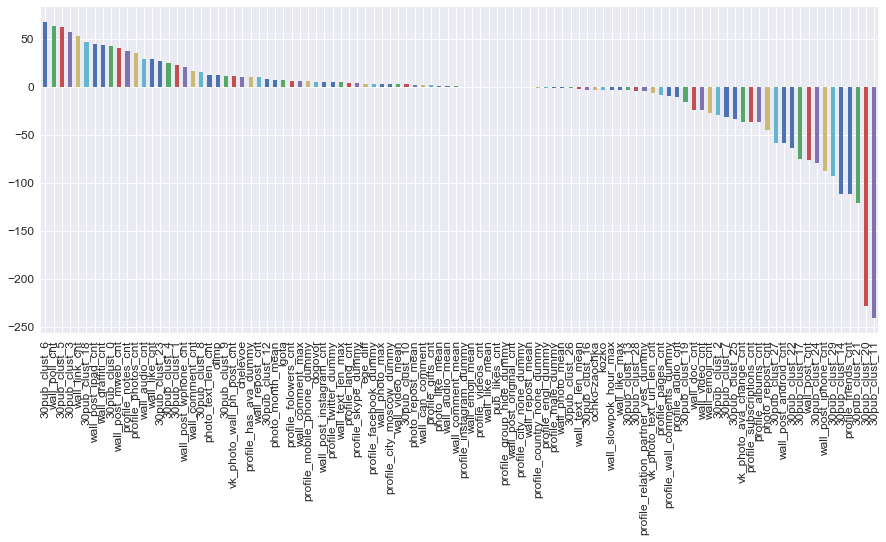

In [134]:
imps = pd.Series([cf for cf in lr.coef_[0]],index=varnames)

lasso_features = np.array(imps[imps != 0].index)

imps = imps.sort_values(ascending=False)[:len(lasso_features)]
imps.plot(kind='bar', figsize=(15,6), fontsize=12)

# Оставляем только незанулившиеся переменные 
ind_lasso = np.array([np.where(varnames == ft)[0][0] for ft in lasso_features])

# 4. Решётка

In [135]:
from sklearn.grid_search import GridSearchCV

parameters_grid = {
    # 'penalty' : ['l1', 'l2'],
    'C' : np.linspace(0.0000000001, 5, num = 100)
}

gridsearch = GridSearchCV(LogisticRegression(penalty = 'l1', class_weight='balanced'), 
                            parameters_grid, scoring = 'roc_auc', cv = 5)

gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'C': 0.1010101011080808}

Качество на кросс-валидации: 0.664057017544 

Число переменных: 10
Train accuracy 0.698529411765
Test accuracy 0.671052631579 

Train roc-auc 0.735948055355
Test roc-auc 0.654166666667


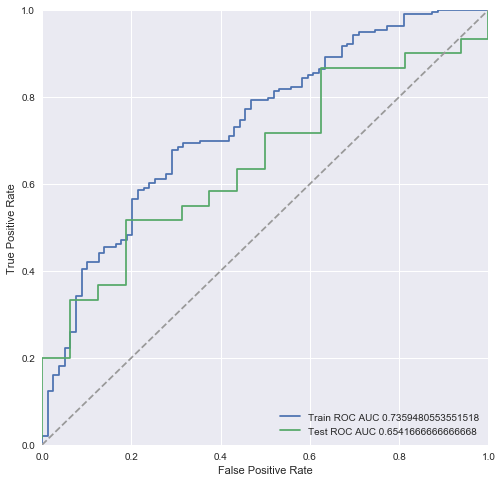

In [136]:
# Обучаем логистическую регрессию 
lr = LogisticRegression(penalty='l1', C = 0.1, class_weight='balanced')
lr.fit(X_train, y_train)

# Качество модели на кросс-валидации 
scoring = cross_val_score(lr, X_train, y_train, scoring = 'roc_auc', cv =5)
print('Качество на кросс-валидации:', scoring.mean(), '\n')

print('Число переменных:', len([var for var in lr.coef_[0] if abs(var) > 0]))

# Качество на трэйне и тесте и картинка
printer(lr)
roc_auc_pic(lr)

# 5. Отбор переменных с помощью Lasso 

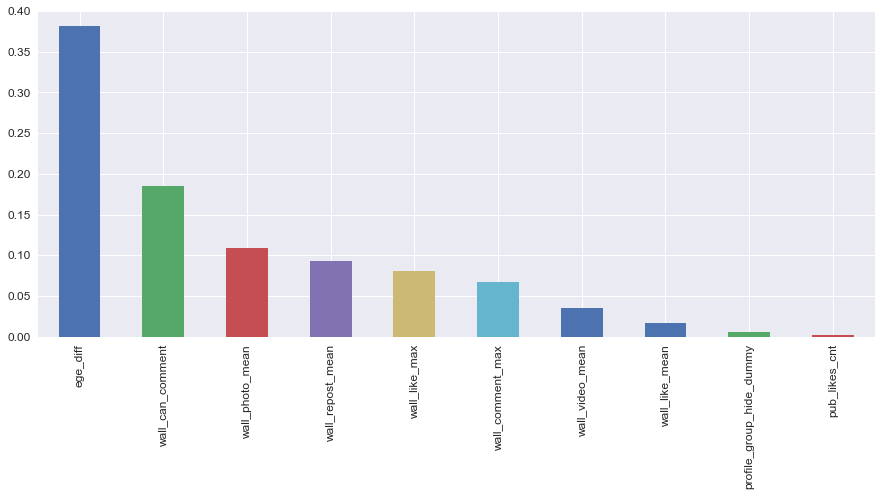

In [137]:
imps = pd.Series([abs(cf) for cf in lr.coef_[0]],index=varnames)

lasso_features = np.array(imps[imps > 0].index)

imps = imps.sort_values(ascending=False)[:len(lasso_features)]
imps.plot(kind='bar', figsize=(15,6), fontsize=12)

# Оставляем только незанулившиеся переменные 
ind_lasso = np.array([np.where(varnames == ft)[0][0] for ft in lasso_features])

In [138]:
X_train_sub = X_train[:,ind_lasso]
X_test_sub = X_test[:,ind_lasso]

# 6.  Добавляем PCA 

In [139]:
from sklearn.decomposition import PCA
my_pca = PCA(n_components=5) 
X_tr_pca = my_pca.fit_transform(X_train)

lr_pca = LogisticRegression(C=10**10, class_weight='balanced')
lr_pca.fit(X_tr_pca, y_train)

scoring = cross_val_score(lr_tsne, X_tr_pca, y_train, scoring = 'roc_auc', cv =5)
print('Качество на кросс-валидации:', scoring.mean(), '\n')

X_test_pca = my_pca.transform(X_test)
printer(lr_pca, X_test=X_test_pca, X_train=X_tr_pca)

NameError: name 'lr_tsne' is not defined

In [ ]:
X_train_2 = np.hstack((X_train_sub, X_tr_pca))
X_test_2 = np.hstack((X_test_sub, X_test_pca))
print(X_train_2.shape, X_test_2.shape)

scoring = cross_val_score(lr_pca, X_train_2, y_train, scoring = 'roc_auc', cv =3)
print('Качество на кросс-валидации:', scoring.mean(), '\n')
lr_pca.fit(X_train_2, y_train)

printer(lr_pca, X_test=X_test_2, X_train=X_train_2)

# 7. Прогнозы 

In [ ]:
lr_pred = lr#_pca
X_test_pr = X_test#_2

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_score = lr_pred.decision_function(X_test_pr)

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [ ]:
yht = 1*(lr_pred.predict_proba(X_test_pr)[:,-1] > 0.4)
cm = confusion_matrix(y_test, yht)
plot_confusion_matrix(cm, classes=['0', '1'])

report = classification_report(y_test, yht)
print(report)

In [ ]:
name_pred = [(a,b[0],b[1]) for a, b in zip(names_2016, zip(lr_pred.predict_proba(X_test_pr)[:,-1],y_test))]
for a,b,c in sorted(name_pred, key=lambda w: w[1], reverse=True):
    print('',a, b, c,'' ,sep = '|')

In [ ]:
name_pred = [(a,b) for a, b in zip(names_2017, lr_pred.predict_proba(X_2017)[:,-1])]
for a,b in sorted(name_pred, key=lambda w: w[1], reverse=True):
    print('',a, b,'' ,sep = '|')

In [ ]:
pd.DataFrame(sorted(name_pred, key=lambda w: w[1], reverse=True)).to_csv('1_k.csv',sep='\t')

# 8. Простенькая нейросеточка или трэш-угар

In [140]:
import keras
from keras.models import Sequential   # Последовательность слоёв
import keras.layers as L              # Разные слои
import keras.optimizers as opt        # Оптимизаторы
from keras.utils.np_utils import to_categorical  # Для преобразования y в категориальный формат 

Using TensorFlow backend.


In [141]:
def get_new_model(order):
    # Задаём модель и называем её Ахмед
    model = Sequential(name = 'Julia')

    # Добавляем в нашу модель первый слой из 20 нейронов
    # На вход в эти 25 нейронов будут индти все наши регрессоры
    model.add(L.Dense(8, input_dim = order, kernel_initializer='random_normal'))
    
    model.add(L.Dropout(0.5))
    # Добавляем функцию активации на первый слой 
    model.add(L.Activation('relu'))

    # Добавляем ещё один слой из 25 нейронов
    model.add(L.Dense(8, kernel_initializer='random_normal'))
    model.add(L.Dropout(0.5))
    model.add(L.Activation('relu'))

    # На выходе мы должны получить вероятности того, что объект относится к разным классам 
    # Сделать такое преобразование позволяет softmax как функция активации
    # На выход будет идти 2 вероятности по числу классов
    model.add(L.Dense(2, activation='softmax', kernel_initializer = 'random_normal'))

    # В качестве оптимизации будем использовать Adam
    optimizer = opt.Adam(lr=1e-3)

    # Собираем модельa
    model.compile(loss = 'categorical_crossentropy', metrics=["accuracy"], optimizer=optimizer)
    return model

In [142]:
np.random.seed(42)
model = get_new_model(X_train_sub.shape[1])

In [143]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 88        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
activation_2 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
Total para

In [144]:
np.random.seed(42)
hist = model.fit(X_train_sub, to_categorical(y_train), validation_split=0.2, epochs=140,
                   verbose=0)

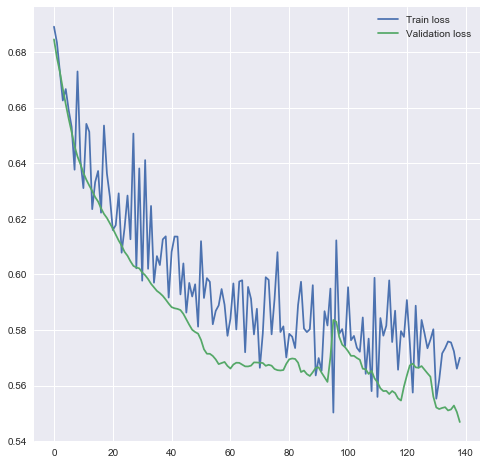

In [145]:
start = 1
plt.plot(hist.history['loss'][start:])
plt.plot(hist.history['val_loss'][start:])
plt.legend(['Train loss', 'Validation loss'])

In [146]:
# Можно предсказать вероятности для тестовой выборки
model.predict_proba(X_test_sub)[:,-1]

array([ 0.78342116,  0.65323281,  0.77161169,  0.70900363,  0.67211705,
        0.87703359,  0.77274877,  0.62268633,  0.63459516,  0.80986738,
        0.59351569,  0.64620298,  0.81456345,  0.61424881,  0.5844484 ,
        0.70774788,  0.67652404,  0.79843736,  0.76830828,  0.74807698,
        0.82676345,  0.74142969,  0.81077826,  0.69988656,  0.84815717,
        0.66284716,  0.78275973,  0.81510043,  0.68592566,  0.62698001,
        0.90158468,  0.75933468,  0.68476421,  0.6927526 ,  0.64895809,
        0.63076591,  0.65556937,  0.71223539,  0.61685991,  0.7606889 ,
        0.76032108,  0.84171414,  0.67648166,  0.63168579,  0.65420181,
        0.7417962 ,  0.63521212,  0.6483025 ,  0.75364226,  0.64442271,
        0.60869408,  0.74319381,  0.74421686,  0.60364872,  0.58809447,
        0.61120224,  0.58630604,  0.60378361,  0.98422766,  0.79375803,
        0.64400065,  0.74285966,  0.66844612,  0.89836127,  0.9725011 ,
        0.84759647,  0.7892127 ,  0.59614569,  0.74070746,  0.61

In [147]:
# А можно классы 
model.predict_classes(X_test_sub)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

Train accuracy 0.709558823529
Validation accuracy 0.789473684211 

Train roc-auc 0.753689250344
Validation roc-auc 0.735416666667


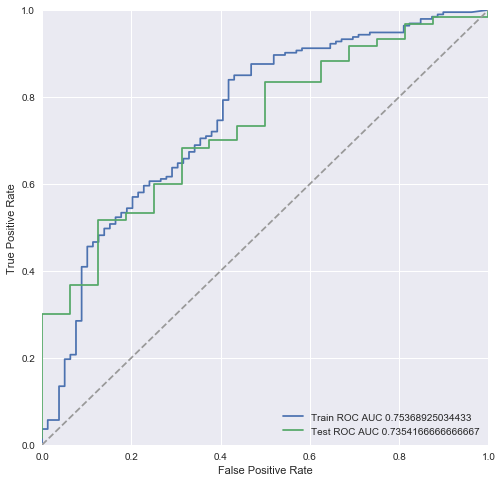

In [148]:
y_tr_hat_nn = model.predict_classes(X_train_sub)
y_ts_hat_nn = model.predict_classes(X_test_sub)

y_hat_train = model.predict_proba(X_train_sub)[:,-1]
y_hat_test = model.predict_proba(X_test_sub)[:,-1]

print ('Train accuracy', accuracy_score(y_train, y_tr_hat_nn))
print ('Validation accuracy', accuracy_score(y_test, y_ts_hat_nn), '\n')
print ('Train roc-auc', roc_auc_score(y_train, y_hat_train))
print ('Validation roc-auc', roc_auc_score(y_test, y_hat_test))


fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_hat_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
roc_auc_train = roc_auc_score(y_train, y_hat_train)
roc_auc_test = roc_auc_score(y_test, y_hat_test)

matplotlib.rcParams['figure.figsize'] = (8, 8)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

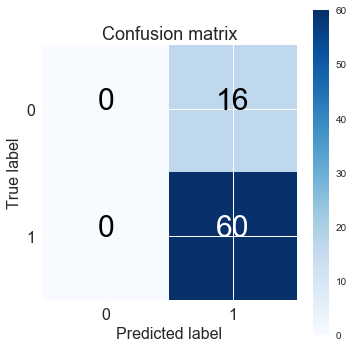

In [149]:
cm = confusion_matrix(y_test, y_ts_hat_nn)
plot_confusion_matrix(cm, classes=['0', '1'])

In [150]:
report = classification_report(y_test, lr.predict(X_test))
print(report)

             precision    recall  f1-score   support

        0.0       0.32      0.50      0.39        16
        1.0       0.84      0.72      0.77        60

avg / total       0.73      0.67      0.69        76



             precision    recall  f1-score   support

        0.0       0.38      0.91      0.53        79
        1.0       0.91      0.38      0.53       193

avg / total       0.76      0.53      0.53       272

0.533088235294


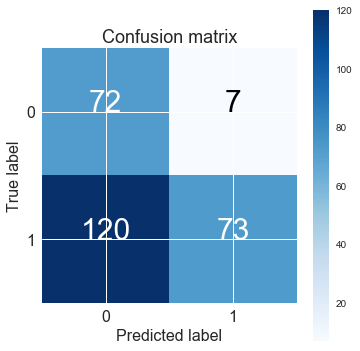

In [151]:
# Отсекаем порог по ROC_AUC 
yhtr = 1*(lr.predict_proba(X_train)[:,-1] > 0.6)

report = classification_report(y_train, yhtr)
print(report)

print(accuracy_score(y_train, yhtr))

cm = confusion_matrix(y_train, yhtr)
plot_confusion_matrix(cm, classes=['0', '1'])

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        16
        1.0       0.79      1.00      0.88        60

avg / total       0.62      0.79      0.70        76

0.789473684211


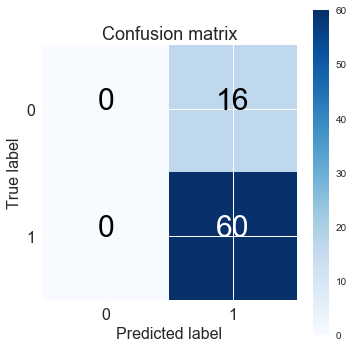

In [152]:
# Отсекаем порог по ROC_AUC 
yhtr = 1*(lr.predict_proba(X_test)[:,-1] > 0.2)

report = classification_report(y_test, yhtr)
print(report)

print(accuracy_score(y_test, yhtr))

cm = confusion_matrix(y_test, yhtr)
plot_confusion_matrix(cm, classes=['0', '1'])

In [153]:
name_pred = [(a,b[0],b[1]) for a, b in zip(names_2016, zip(model.predict_proba(X_test_sub)[:,-1],y_test))]
sorted(name_pred, key=lambda w: w[1], reverse=True)

[('Андреев Даниил', 0.98422766, 1.0),
 ('Шаброва Анастасия', 0.9725011, 1.0),
 ('Селиванова Виктория', 0.90158468, 1.0),
 ('Петров Илья', 0.89836127, 1.0),
 ('Касьянова Ксения', 0.87703359, 1.0),
 ('Федорчук Яна', 0.84815717, 1.0),
 ('Скиба  Виталий', 0.84759647, 1.0),
 ('Анищик Анастасия', 0.84171414, 1.0),
 ('Левит Виктория', 0.82676345, 1.0),
 ('Иванова Наталья', 0.81510043, 1.0),
 ('Лобкова Дарья', 0.81456345, 1.0),
 ('Кулак Ксения', 0.81077826, 1.0),
 ('Суюнбаев Ислам', 0.80986738, 1.0),
 ('Гареев Михаил', 0.79843736, 1.0),
 ('Ерёмин Владимир', 0.79375803, 1.0),
 ('Свистельникова Татьяна', 0.7892127, 1.0),
 ('Яковлева Елизавета', 0.78342116, 1.0),
 ('Распутняя Альбина', 0.78275973, 1.0),
 ('Митдзиев Азамат', 0.77274877, 0.0),
 ('Кузнецова Елизавета', 0.77161169, 1.0),
 ('Гусевская Алина', 0.76830828, 1.0),
 ('Зарманбетов Ахмед', 0.76532304, 1.0),
 ('Бекирова Ольга', 0.7606889, 1.0),
 ('Григорьев Кирилл', 0.76032108, 0.0),
 ('Алексеева Дарья', 0.75933468, 1.0),
 ('Колотовкина Анаст

# 9. Случайный лес

Качество на кросс-валидации: 0.702093397746 

Train accuracy 0.988970588235
Test accuracy 0.657894736842 

Train roc-auc 0.998721059881
Test roc-auc 0.619270833333


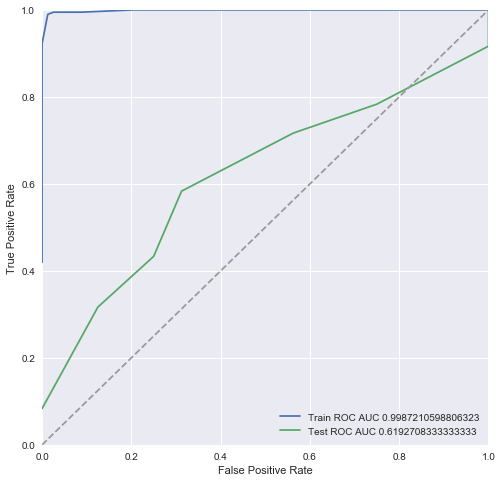

In [154]:
np.random.seed(42)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10,max_features='sqrt',random_state=42)
rf.fit(X_train, y_train)

# Качество модели на кросс-валидации 
scoring = cross_val_score(rf, X_train, y_train, scoring = 'accuracy', cv =3)
print('Качество на кросс-валидации:', scoring.mean(), '\n')

printer(rf)
roc_auc_pic(rf)

# 10.  Xgboost

In [155]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

gbm = xgb.XGBClassifier( )

gbm_param_grid = {
    "colsample_bytree" : np.linspace(0.2,1,num=10),
    "subsample" : np.linspace(0.2,1,num=10),
    "n_estimators" : range(10,50),
    "max_depth" : range(2,12),
    "learning_rate": np.linspace(0,0.2,num=10),
    "gamma": np.linspace(0,10,num=21),
    #'reg_alpha': np.linspace(0,50,num=21),
    "min_child_weight": np.linspace(0,20,num=21)
}

# Если выборка большая, ставить 1000 итераций - плохая идея, так как будет обучаться 4000 моделей
randomized_mse = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid, 
                                    scoring="accuracy", cv=4, verbose=1,n_iter=1000)

randomized_mse.fit(X_train,y_train)

print("Лучшие параметры: ", randomized_mse.best_params_)
print('\n')
print("Самый крутой accuracy: ", randomized_mse.best_score_)

printer(randomized_mse)

Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
Лучшие параметры:  {'subsample': 0.46666666666666667, 'n_estimators': 17, 'min_child_weight': 2.0, 'max_depth': 7, 'learning_rate': 0.20000000000000001, 'gamma': 0.5, 'colsample_bytree': 0.64444444444444449}


Самый крутой accuracy:  0.772058823529
Train accuracy 0.900735294118
Test accuracy 0.75 

Train roc-auc 0.957303076015
Test roc-auc 0.651041666667


[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:  2.4min finished


# 11. TSNE 

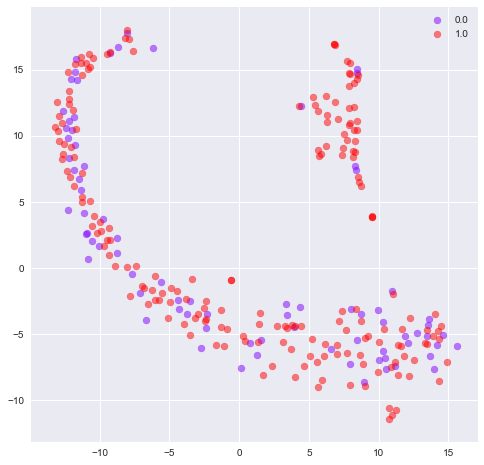

In [156]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm # импортируем цветовые схемы, чтобы рисовать графики.

My_TSNE = TSNE(random_state=321)
tsne_representation = My_TSNE.fit_transform(X_train)

y = y_train

colors = cm.rainbow(np.linspace(0, 1, len(set(y))))
for yy,c in zip(set(y), colors):
    plt.scatter(tsne_representation[y == yy, 0],
                tsne_representation[y == yy, 1], c=c, alpha = 0.5, label = str(yy))
plt.legend()

In [157]:
data.ix[tsne_representation[:,0] < -10].head() 

,firstname,lastname,year,lgota,chelevoe,olimp,dogovor,ochko-zaochka,ege_diff,kozko,...,30pub_clust_21,30pub_clust_22,30pub_clust_23,30pub_clust_24,30pub_clust_25,30pub_clust_26,30pub_clust_27,30pub_clust_28,30pub_clust_29,pub_likes_cnt
10,Осипов,Семён,2012,0,0.0,0,0,0,27.0,0,...,1.28e-02,9.66e-03,6.59e-03,3.42e-03,0.03,3.80e-03,1.28e-02,0.13,2.68e-03,44.0
19,Рубан,Анна,2012,0,0.0,0,0,0,16.0,0,...,2.81e-03,6.53e-02,6.70e-03,6.81e-02,0.05,2.10e-03,7.39e-04,0.04,0.00e+00,30.0
27,Прибыльский,Денис,2012,0,0.0,0,0,0,8.0,0,...,2.51e-02,2.13e-02,1.05e-03,5.31e-03,0.06,6.71e-03,1.25e-02,0.06,7.24e-04,58.0
31,Шевченко,Екатерина,2012,0,0.0,0,0,0,7.0,0,...,3.96e-02,3.93e-03,2.41e-03,2.55e-04,0.05,4.48e-03,8.96e-03,0.05,0.00e+00,73.0
37,Соловей,Владислав,2012,0,0.0,0,0,0,5.0,0,...,2.36e-02,1.47e-02,1.46e-03,1.62e-03,0.07,1.89e-02,7.99e-03,0.07,1.58e-03,33.0


In [158]:
My_TSNE = TSNE(random_state=321)
tsne_representation = My_TSNE.fit_transform(np.vstack((X_train,X_test)))

X_tsne_train = tsne_representation[:X_train.shape[0],:]
X_tsne_test = tsne_representation[X_train.shape[0]:X_train.shape[0]+X_test.shape[0],:]                                       

In [159]:
lr_tsne = LogisticRegression(C=10**10)
lr_tsne.fit(X_tsne_train, y_train)

scoring = cross_val_score(lr_tsne, X_tsne_train, y_train, scoring = 'roc_auc', cv =5)
print('Качество на кросс-валидации:', scoring.mean(), '\n')

printer(lr_tsne,X_test = X_tsne_test, X_train=X_tsne_train)

Качество на кросс-валидации: 0.551762820513 

Train accuracy 0.709558823529
Test accuracy 0.789473684211 

Train roc-auc 0.577293893881
Test roc-auc 0.605208333333


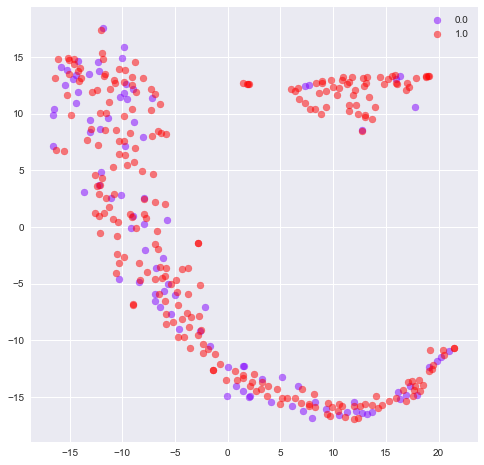

In [160]:
y = np.array(list(y_train) + list(y_test))

colors = cm.rainbow(np.linspace(0, 1, len(set(y))))
for yy,c in zip(set(y), colors):
    plt.scatter(tsne_representation[y == yy, 0],
                tsne_representation[y == yy, 1], c=c, alpha = 0.5, label = str(yy))
plt.legend()

In [171]:
nms = data.ix[(tsne_representation[:,1] >5)&(tsne_representation[:,0] > 0)][['firstname','lastname']].get_values()
for item in nms:
    print(item[0],item[1])

Данильченко Леонид
Кочеткова Полина
Канаева Дельгир
Нагшбанди Рабиа
Шабалина Ольга
Ольхова Ольга
Упатова Яна
Глазова Александра
Головко Алексей
Фокин Никита
Малахов Кирилл
Алёшина Александра
Крылова Анна
Карцева Анна
Царев  Алексей
Степанова Елена
Кривченко Анастасия
Островский Кирилл
Лобачёва Дарья
Кушнерева Мария
Поспелов  Сергей
Гурьянов Игорь
Максимов  Иван
Шемякина Кира
Дуров Илья
Мелкоян  Гоар
Тюменцев  Вячеслав
Тюменцев Вячеслав
Лавыгин Илья
Кулешова Евгения
Гадий Людмила
Лобжанидзе Лилиана
Кинякина Ксения
Аванесов Семён
Гильдин Марк
Митдзиев Азамат
Бобылёв Иван
Лобкова Дарья
Хомутов Александр
Васильева Александра
Гусевская Алина
Фоломеев Александр
Федорчук Яна
Иванова Наталья
Алексеева Дарья
Ященко Арина
Канцевич Дарья
Изидорчик  Ксения
Алексеева Дарья
Андреев Даниил
Ерёмин Владимир
Куркин Николай
Дзюба Артём
Самойлова Катя
Корчагин Максим
Скибенко Светлана
Говоркова Дарья
Лушина Валерия
Рединская Наталья
Ахмедова Вазифа
Аксенова Анна
Буханов Денис
Хачатрян Гарик
Зыкин Иван


<img align="center" src="http://img0.reactor.cc/pics/post/ванга-мемгенератор-59018.jpeg" width="300">


<img align="center" src="https://raw.githubusercontent.com/FUlyankin/Parsers/master/images%20/cats.jpg" height="1200" width="1200">